# 合成データを用いてフィードバックループ起因のバイアスを探る
参考: https://dl.acm.org/doi/10.1145/3308560.3317303

In [1]:
import sys; sys.path.append('..')
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import warnings
from scipy import spatial
from tqdm import tqdm
from numpy.linalg import inv
from multiprocessing import Pool, cpu_count
from util.plot import plot_heatmap, plot_train_curve, plot_rec_count
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(12345)
warnings.filterwarnings('ignore')

In [2]:
# util functions

def calculate_popularity_model(rating_df,t):
    propensity_score = []
    ratings = rating_df.values
    for i in range(ratings.shape[1]):
        propensity_score.append(float(np.count_nonzero(ratings[:,i]))/ratings.shape[0])
    
    temp = np.array(propensity_score)
    temp = temp.reshape((1,len(temp)))
    new_df = pd.DataFrame(temp,columns=rating_df.columns.values)
    new_df.index= ['time'+str(t)]
    return new_df

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

# ユーザーの組み合わせごとにJaccard係数を計算する
def calc_jaccard(pair, rated_items):
    u, v = pair
    intersection = len(rated_items[u].intersection(rated_items[v]))
    union = len(rated_items[u].union(rated_items[v]))
    return intersection / union

In [3]:
def Conventional_MF_random(addnum):
    
    training_error_regular = []
    testing_error_regular = []
    gini_regular = []
    bs_percentile_conv_MF = []
    jaccard_indices_regular = []
    
    topN = 20
    threshold = 0.1  ## the most popular times threshold 
    
    popularity_aggregate_regular = pd.DataFrame(columns=Data_time.columns)
    time_mask = Data_time.values<=3 ### provide the first time rating matrix
    # ユーザーの組み合わせを作成する
    user_pairs = [(u, v) for u in range(num_user) for v in range(u+1, num_user)]
    
    ## testing set
    for t in tqdm(range(1,21)):

        R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        
        prop_score = calculate_popularity_model(R_df,t)  
    #     ### with NMF from sklearn
        model = NMF(n_components=10, init='random', max_iter=200)
        W = model.fit_transform(R_df.values)
        H = model.components_
        pred = np.dot(W, H)
        pred_data = pd.DataFrame(pred,index=R_df.index,columns=R_df.columns)

        popularity_aggregate_regular = popularity_aggregate_regular.append(prop_score)
        t1 = prop_score.values.tolist()
        IversPropensity = []
        for i in range(Data.shape[0]):
            IversPropensity.append(t1)

        ###### calculate gini score 
        gini_score = gini(prop_score.values/np.sum(prop_score.values))
        gini_regular.append(gini_score)
#         print gini_score
#         ### error for training
        mask = R_df.values>0
        rmse= np.sqrt(np.sum(np.power(pred-R_df.values,2)*mask)/np.sum(mask))
        mae= np.sum(np.abs(pred-R_df.values)*mask)/np.sum(mask)
        training_error_regular.append([rmse,mae])

        #### select the top 10 item for each user
        #### change the mask (set cell to True which are selected to present to user)
        ## choose 10 item every time to a user
        num= addnum
        candidate_index = ~time_mask  ## convert all candidate index to True
        candidate_rating = pred_data*candidate_index ## get predicte rating on those candidate index
        sorted_ind = np.argsort(-candidate_rating,axis=1).iloc[:,:] ## get the index of each row, where top n pred are selected
        row_num = 0
        for index, row in sorted_ind.iterrows():
            ### choose random items with length of num
            lis = row.values.tolist()
#             print lis
            item_selected = np.random.choice(lis, num,replace=False)
#             print item_selected
            candidate_index[row_num,item_selected] = False  ## remove those selected item from candidate pool 
            row_num = row_num+1
        time_mask = ~candidate_index  ## get the new index 
        
        ### check result on testing set
        rmse= np.sqrt(np.sum(np.power(pred-test_df.values,2)*test_mask)/np.sum(test_mask))
        mae= np.sum(np.abs(pred-test_df.values)*test_mask)/np.sum(test_mask)
        testing_error_regular.append([rmse,mae])
        
        ### ジャッカード指数計算
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        # 複数のプロセスを使ってJaccard係数を計算する
        with Pool(cpu_count()-1) as p:
            jaccard_indices = p.starmap(calc_jaccard, [(u, rated_items) for u in user_pairs])
        jaccard_indices_regular.append(np.mean(jaccard_indices))
        
    
    R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)    
        
    return training_error_regular,testing_error_regular,gini_regular,jaccard_indices_regular,R_df

In [4]:
def Conventional_MF(addnum):
    
    training_error_regular = []
    testing_error_regular = []
    gini_regular = []
    bs_percentile_conv_MF = []
    jaccard_indices_mf = []
    
    topN = 20
    threshold = 0.1  ## the most popular times threshold 

    popularity_aggregate_regular = pd.DataFrame(columns=Data_time.columns)
    time_mask = Data_time.values<=3 ### provide the first time rating matrix
    # ユーザーの組み合わせを作成する
    user_pairs = [(u, v) for u in range(num_user) for v in range(u+1, num_user)]
    
    ## testing set
    for t in tqdm(range(1,21)):
        R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        prop_score = calculate_popularity_model(R_df,t)  
    #     ### with NMF from sklearn
        model = NMF(n_components=10, init='random', max_iter=200)
        W = model.fit_transform(R_df.values)
        H = model.components_
        pred = np.dot(W, H)
        pred_data = pd.DataFrame(pred,index=R_df.index,columns=R_df.columns)

        ## check diversity
        #rec_ratings= get_top_n_list_for_users(W,H, R_df,topN)
        #thre = np.max(prop_score.values.tolist())*(1-threshold)
        #mean_prec, mean_recall, mean_diversity, mean_novelty = evaluate(R_df, test_df.values,topN,rec_ratings,W,H,prop_score.values.tolist(),thre)
        #diversity.append(mean_diversity)
        #novelty.append(mean_novelty)

        popularity_aggregate_regular = popularity_aggregate_regular.append(prop_score)
        t1 = prop_score.values.tolist()
        IversPropensity = []
        for i in range(Data.shape[0]):
            IversPropensity.append(t1)

        ###### calculate gini score 
        gini_score = gini(prop_score.values/np.sum(prop_score.values))
        gini_regular.append(gini_score)

#         ### error for training
        mask = R_df.values>0
        rmse= np.sqrt(np.sum(np.power(pred-R_df.values,2)*mask)/np.sum(mask))
        mae= np.sum(np.abs(pred-R_df.values)*mask)/np.sum(mask)
        training_error_regular.append([rmse,mae])

        #### select the top 10 item for each user
        #### change the mask (set cell to True which are selected to present to user)
        ## choose 10 item every time to a user
        num=addnum
        candidate_index = ~time_mask  ## convert all candidate index to True
        candidate_rating = pred_data*candidate_index ## get predicte rating on those candidate index
        sorted_ind = np.argsort(-candidate_rating,axis=1).iloc[:,:num] ## get the index of each row, where top n pred are selected

        row_num = 0
        for index, row in sorted_ind.iterrows():
            ### choose random items with length of num
            item_selected = row.values.tolist()
            candidate_index[row_num,item_selected] = False  ## remove those selected item from candidate pool 
            row_num = row_num+1
        time_mask = ~candidate_index  ## get the new index
        
        ### check result on testing set
        rmse= np.sqrt(np.sum(np.power(pred-test_df.values,2)*test_mask)/np.sum(test_mask))
        mae= np.sum(np.abs(pred-test_df.values)*test_mask)/np.sum(test_mask)
        testing_error_regular.append([rmse,mae])
        
        ### ジャッカード指数計算
        rated_matrix = R_df.values
        rated_items = {u: set(np.nonzero(rated_matrix[u])[0]) for u in range(num_user)}
        # 複数のプロセスを使ってJaccard係数を計算する
        with Pool(cpu_count()-1) as p:
            jaccard_indices = p.starmap(calc_jaccard, [(u, rated_items) for u in user_pairs])
        jaccard_indices_mf.append(np.mean(jaccard_indices))
    

    R_df = pd.DataFrame(Data.values*time_mask,index=Data.index,columns=Data.columns)
        
    return training_error_regular,testing_error_regular,gini_regular,jaccard_indices_mf,R_df
        

In [5]:
### work with synthetic data
num_user = 500
num_item = 1000
epsilon = 0.5
ratings = np.zeros((num_user,num_item))
u_i_r = []
for u in range(num_user):
    au  = np.random.normal(3.4,1,1)
    bu = np.random.normal(0.5,0.5, 1)
    for i in range(num_item):
        ti = np.random.normal(0.1,1,1)
        eij = np.random.normal(0,1,1)

        a= au+bu*ti+epsilon*eij
        r = max(min(round(a[0]),5),1)
        ratings[u][i] = r
        u_i_r.append([u, i, r])

column_names=['item'+str(j) for j in range(ratings.shape[1])]
indexes = ['user'+str(i) for i in range(ratings.shape[0])]
Data = pd.DataFrame(ratings,index=indexes,columns=column_names)
u_i_r = np.array(u_i_r)

Time_range = 40  ## split the ratings into 40 time range
column_names=['item'+str(j) for j in range(ratings.shape[1])]
indexes = ['user'+str(i) for i in range(ratings.shape[0])]
rated_time = np.random.randint(1,Time_range,size=(ratings.shape[0],ratings.shape[1]))
Rated_Time = pd.DataFrame(rated_time,index=indexes,columns=column_names)
Data_time = Rated_Time
       
## global pars

add_num=10

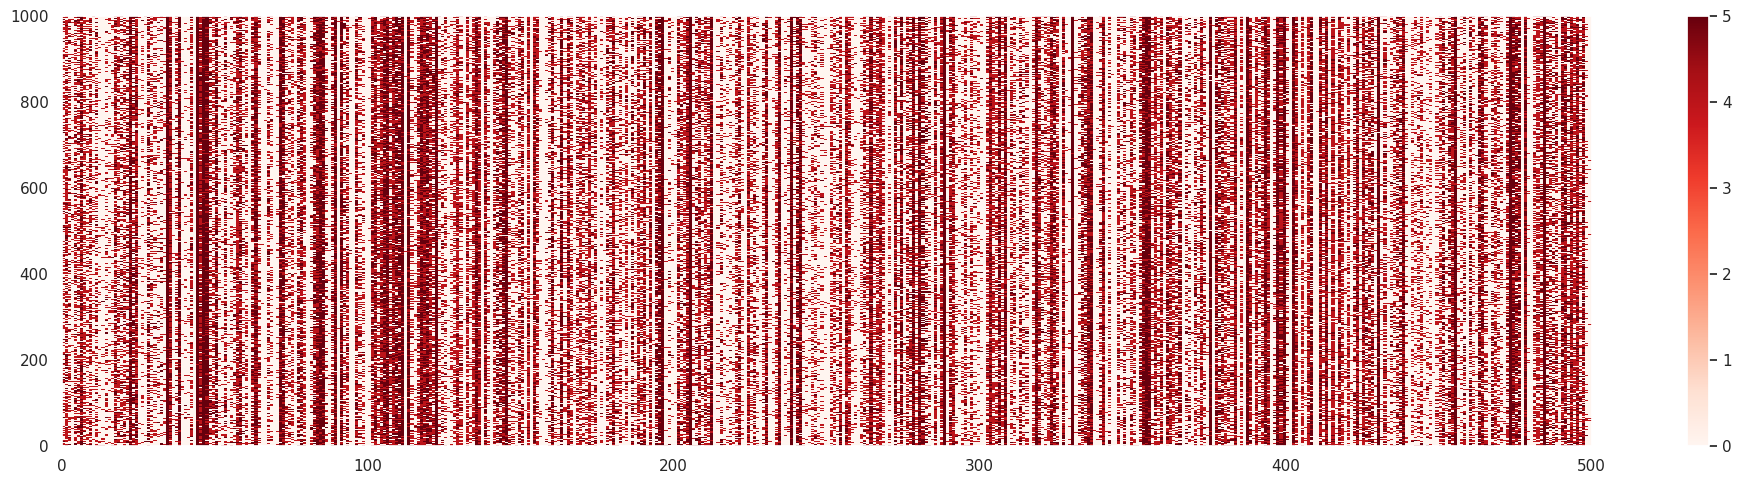

In [6]:
high_r = np.where(ratings>=4, ratings, 0)
orderd_high_r = np.sort(np.count_nonzero(high_r, axis=0))[::-1]

plot_heatmap(high_r)

In [7]:
orderd_high_r = np.sort(np.count_nonzero(~np.isnan(high_r), axis=0))[::-1]

In [8]:
from util.recommend import generate_rec_list
from src.MF import MF

addnum = 10

def AdamMF(universal=False ,addnum=10):
    rate_time = np.random.randint(1, Time_range, size=u_i_r.shape[0])
    data_index = np.array([i for i in range(u_i_r.shape[0])])

    time_mask = rate_time<=3
    train_data = u_i_r[data_index[time_mask]]

    test_mask = (28 <= rate_time) & (rate_time <= 30)
    test_data = u_i_r[data_index[test_mask]]

    uis = u_i_r[:,0]
    iis = u_i_r[:,1]

    # ユーザーの組み合わせを作成する
    user_pairs = [(u, v) for u in range(num_user) for v in range(u+1, num_user)]

    train_losses, test_losses, ginis, jaccards = [], [], [], []
    for _ in tqdm(range(20)):
        train_data = u_i_r[data_index[time_mask]]

        item_counts = np.unique(train_data[:,1], return_counts=True)[1]
        pscore = item_counts / num_user
        gini_score = gini(pscore/pscore.sum())
        ginis.append(gini_score)
    
    
        hist_user = train_data[:,0]

        ### ジャッカード指数計算
        rated_items = {u: set(train_data[hist_user == u][:,1]) for u in range(num_user)}
        # 複数のプロセスを使ってJaccard係数を計算する
        with Pool(cpu_count()-1) as p:
            jaccard_indices = p.starmap(calc_jaccard, [(u, rated_items) for u in user_pairs])
        jaccards.append(np.mean(jaccard_indices))
        
        if universal:
            pscore_arg = dict(pscore=pscore)
        else:
            pscore_arg = dict()
    
        model = MF(
            n_users=num_user,
            n_items=num_item,
            n_factors=300,
            lr=0.01,
            reg=0.2,
            n_epochs=10,
            **pscore_arg
        )
    
        train_loss, test_loss = model.fit(train_data, test_data)
        train_losses.append(train_loss[-1])
        test_losses.append(test_loss[-1])
    
        pred_matrix = model.matrix
        data = np.concatenate([train_data, test_data], axis=0)
        rec_list = generate_rec_list(data, pred_matrix, top_k=addnum)
    
        rec_indices = []
        for user_index, recs in enumerate(rec_list):
            user_mask = np.in1d(uis,user_index)
            item_mask = np.in1d(iis, recs)
            rec_indices.append(list(np.where(user_mask&item_mask)[0]))
    
        rec_indices = np.array(rec_indices).flatten()
        time_mask[rec_indices] = True
    
    return train_losses, test_losses, ginis, jaccards, train_data


In [9]:
## get the unique testing for all different debias strateies
temp = Data_time[(27 <= Data_time) & (Data_time <= 30)]
test_mask = temp.values>0
test_df = pd.DataFrame(Data.values*test_mask,index=Data.index,columns=Data.columns)

## 

N = Data.shape[0]
M = Data.shape[1]
K=10

In [10]:
train_error_regular,test_error_regular,gini_regula, jaccrd_indices_mf, mf_r_mat = AdamMF()

100% 20/20 [11:58<00:00, 35.94s/it]


In [11]:
train_error_ips, test_error_ips, gini_ips, jaccard_ips, ips_r_mat = AdamMF(universal=True)

100% 20/20 [11:59<00:00, 36.00s/it]


In [12]:
train_error_random, test_error_random, gini_random, jaccrd_indices_random, random_r_df = Conventional_MF_random(add_num)

100% 20/20 [00:56<00:00,  2.84s/it]


In [13]:
ips_pivot = pd.DataFrame(ips_r_mat).pivot(index=0, columns=1, values=2).values
mf_pivot = pd.DataFrame(mf_r_mat).pivot(index=0, columns=1, values=2).values

In [14]:
#logged_mat = pd.DataFrame(train_data).pivot(index=0, columns=1, values=2).values
#conditions = (ratings >= 4) & (model.matrix.T < 4)
#plot_heatmap(np.where(conditions, ratings, np.nan))

In [15]:
#np.unique(conditions)

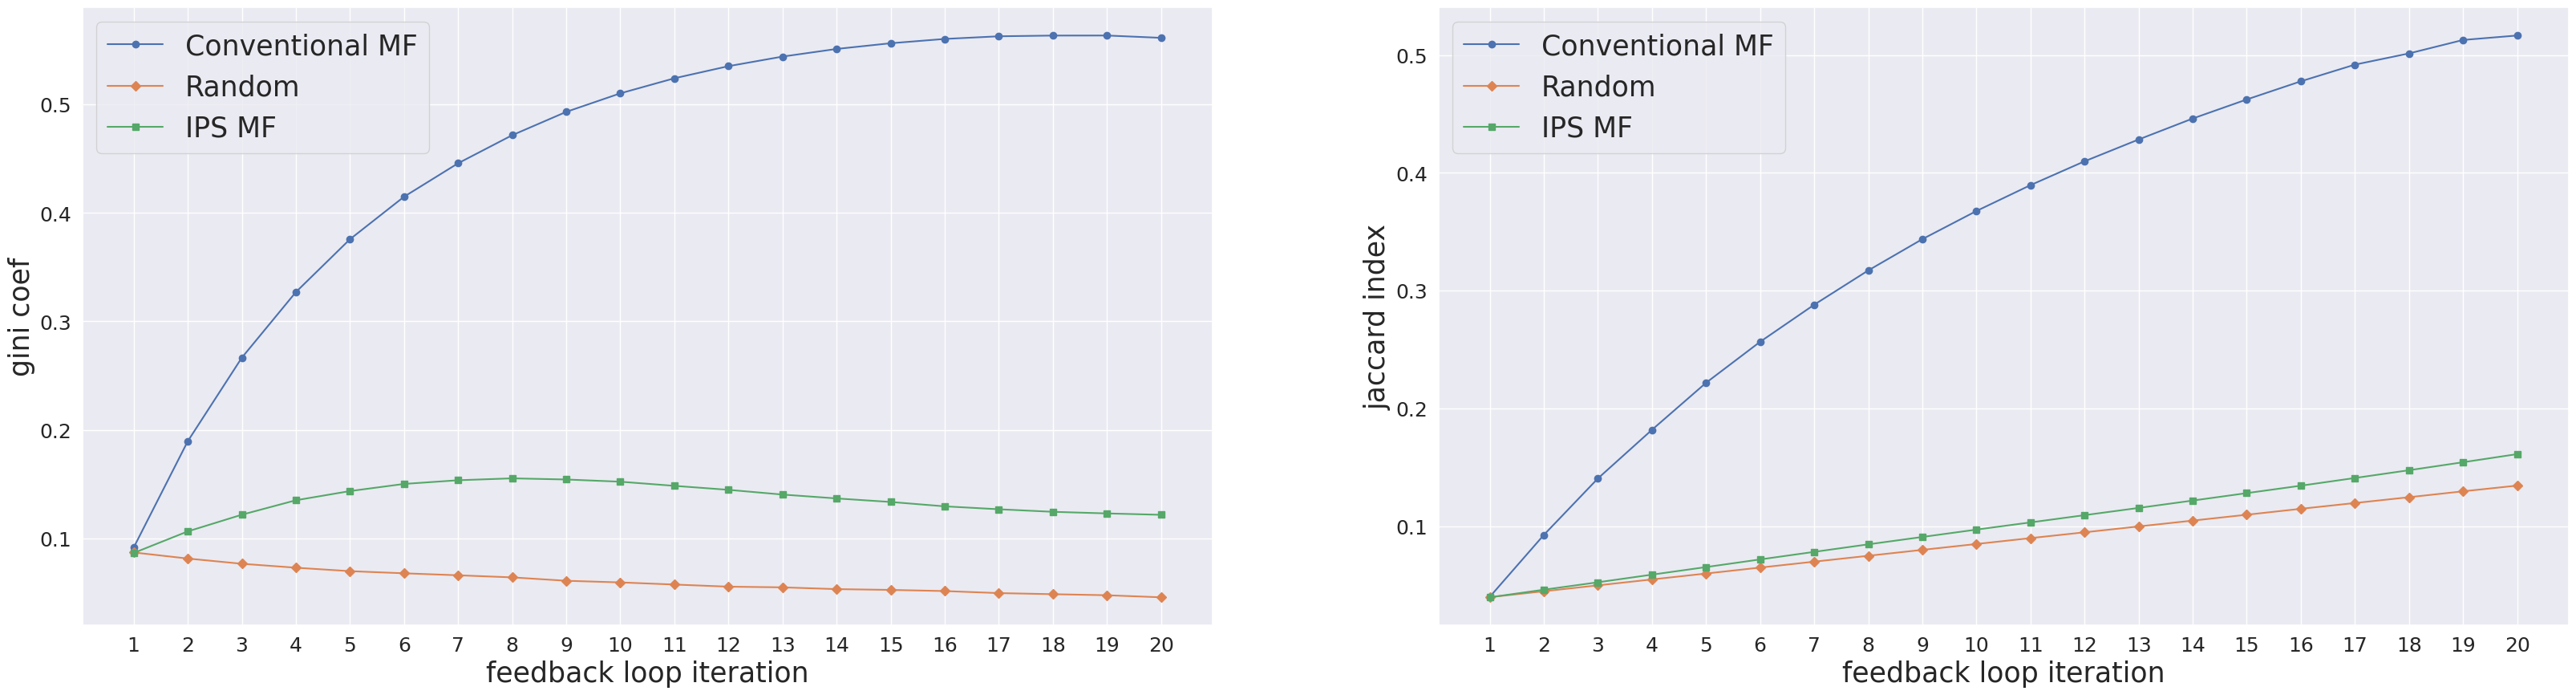

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(40, 10))

#axes[0,0].plot(np.array(train_error_regular), label='Conventional MF', marker='o')
#axes[0,0].plot(np.array(train_error_random)[:,0], label='Random', marker='D')
#axes[0,0].plot(np.array(train_error_ips), label="Adam IPS MF", marker="s")
#axes[0,0].legend(fontsize=12)
#axes[0,0].set_xlabel('iteration', fontsize=18)
#axes[0,0].set_ylabel('training RMSE', fontsize=18)
#axes[0,0].set_xticks(range(0, 20))
#axes[0,0].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
#axes[0,0].tick_params(axis='y', labelsize=18)

#axes[0,1].plot(np.array(test_error_regular), label='Conventional MF', marker='o')
#axes[0,1].plot(np.array(test_error_random)[:,0], label='Random', marker='D')
#axes[0,1].plot(np.array(test_error_ips), label="Adam IPS MF", marker="s")
#axes[0,1].legend(fontsize=12)
#axes[0,1].set_xlabel('iteration', fontsize=18)
#axes[0,1].set_ylabel('testing RMSE', fontsize=18)
#axes[0,1].set_xticks(range(0, 20))
#axes[0,1].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
#axes[0,1].tick_params(axis='y', labelsize=18)

axes[0].plot(np.array(gini_regula), label='Conventional MF', marker='o')
axes[0].plot(np.array(gini_random), label='Random', marker='D')
axes[0].plot(np.array(gini_ips), label="IPS MF", marker="s")
axes[0].legend(fontsize=25)
axes[0].set_xlabel('feedback loop iteration', fontsize=25)
axes[0].set_ylabel('gini coef', fontsize=25)
axes[0].set_xticks(range(0, 20))
axes[0].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)

axes[1].plot(np.array(jaccrd_indices_mf), label='Conventional MF', marker='o')
axes[1].plot(np.array(jaccrd_indices_random), label='Random', marker='D')
axes[1].plot(np.array(jaccard_ips), label="IPS MF", marker="s")
axes[1].legend(fontsize=25)
axes[1].set_xlabel('feedback loop iteration', fontsize=25)
axes[1].set_ylabel('jaccard index', fontsize=25)
axes[1].set_xticks(range(0, 20))
axes[1].set_xticklabels([str(i+1) for i in range(0,20)], fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)

plt.show()

In [17]:
#np.nansum(pd.DataFrame(mf_r_mat).pivot(index=0, columns=1, values=2).values, axis=0)

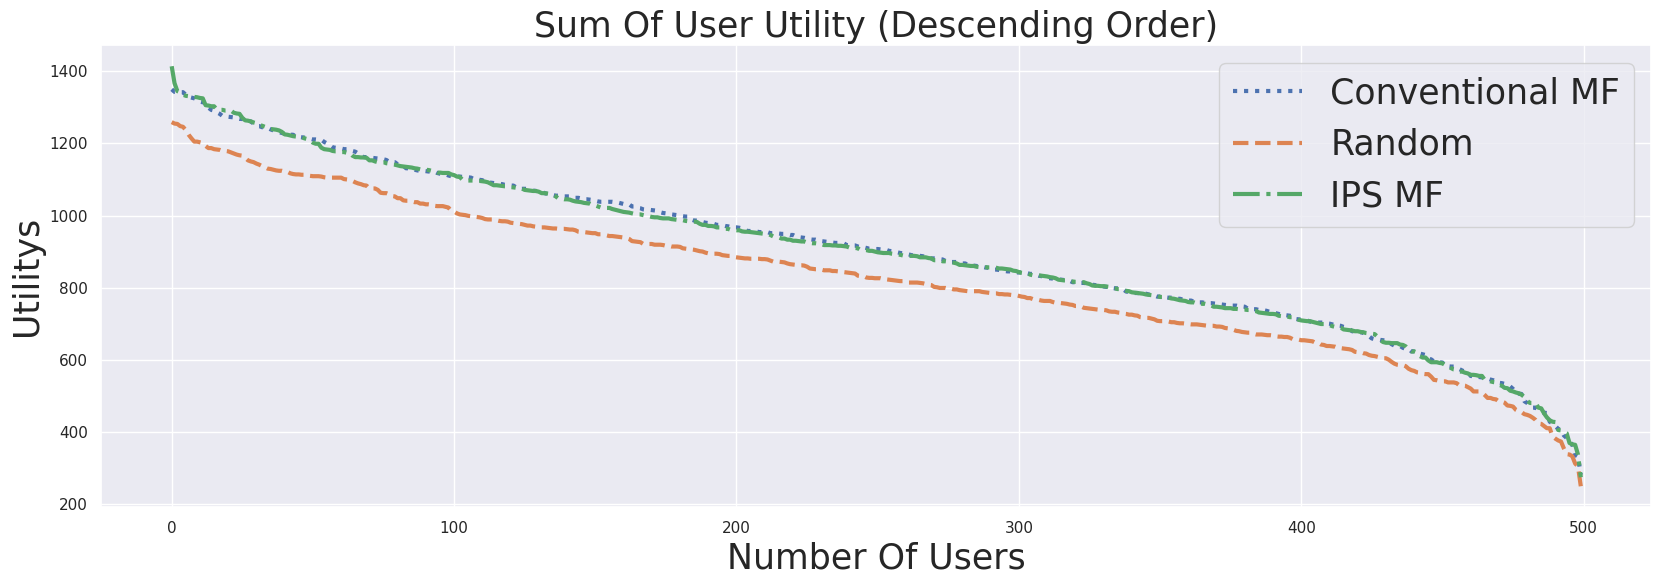

In [31]:
user_utils_mf = np.sort(np.nansum(mf_pivot, axis=1))[::-1] 
user_utils_random = np.sort(random_r_df.values.sum(1))[::-1] 
user_utils_ips = np.sort(np.nansum(ips_pivot, axis=1))[::-1] 
true_utils = np.sort(Data.values.sum(1))[::-1]
users = [u for u in range(num_user)]

plt.figure(figsize=(20,6))
#plt.plot(users, true_utils, linewidth=3, label="True Matrix")
plt.plot(users, user_utils_mf, linewidth=3, label='Conventional MF', linestyle="dotted")
plt.plot(users, user_utils_random, label="Random", linewidth=3, linestyle="dashed")
plt.plot(users, user_utils_ips, label="IPS MF", linewidth=3, linestyle="dashdot")
plt.title('Sum Of User Utility (Descending Order)', fontdict=dict(size=25))
plt.xlabel("Number Of Users", fontdict=dict(size=25))
plt.ylabel("Utilitys", fontdict=dict(size=25))
plt.legend(fontsize=25)


plt.show()

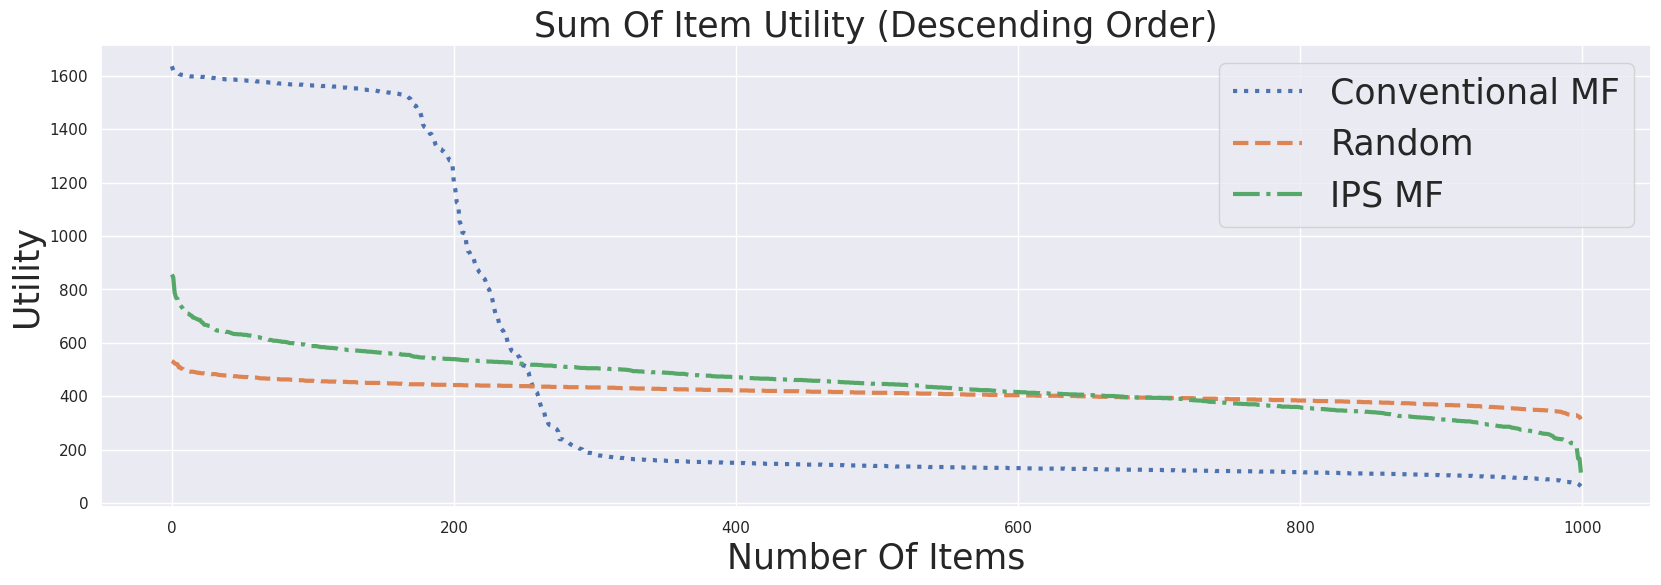

In [38]:
item_utils_mf = np.sort(np.nansum(mf_pivot, axis=0))[::-1] 
item_utils_random = np.sort(random_r_df.values.sum(0))[::-1] 
item_utils_ips = np.sort(np.nansum(ips_pivot, axis=0))[::-1] 
item_utils = np.sort(Data.values.sum(0))[::-1]
items = [i for i in range(num_item)]

plt.figure(figsize=(20,6))
#plt.plot(items, item_utils, linewidth=3, label="True Matrix")
plt.plot(items, item_utils_mf, linewidth=3, label='Conventional MF', linestyle="dotted")
plt.plot(items, item_utils_random, label="Random", linewidth=3, linestyle="dashed")
plt.plot(items, item_utils_ips, label="IPS MF", linewidth=3, linestyle="dashdot")
plt.title('Sum Of Item Utility (Descending Order)', fontdict=dict(size=25))
plt.xlabel("Number Of Items", fontdict=dict(size=25))
plt.ylabel("Utility", fontdict=dict(size=25))
plt.legend(fontsize=25)

plt.show()

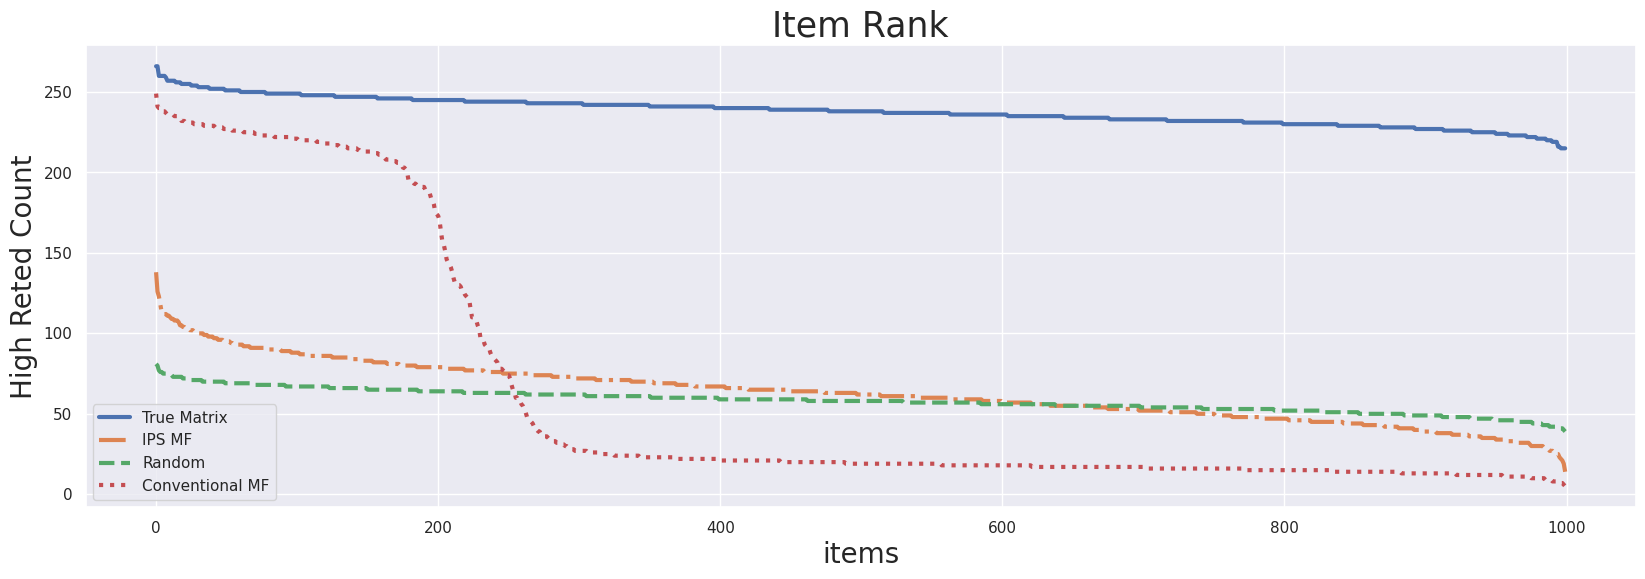

In [21]:
# あまり人気のない商品を高評価してる人にちゃんとそのアイテムを渡せているか確かめる。でなければ普遍学習している意味がない
items = [i for i in range(num_item)]

high_r = np.where(ratings>=4, ratings, 0)
high_ips_mat = np.where(ips_pivot>=4, ips_pivot, 0)
high_random_mat = np.where(random_r_df.values>=4, random_r_df.values, 0)
high_mf_mat = np.where(mf_pivot>=4, mf_pivot, 0)

plt.figure(figsize=(20,6))
plt.plot(items, np.sort(np.count_nonzero(high_r, axis=0))[::-1], linewidth=3, label="True Matrix")
plt.plot(items, np.sort(np.count_nonzero(high_ips_mat, axis=0))[::-1], label="IPS MF", linewidth=3, linestyle="dashdot")
plt.plot(items, np.sort(np.count_nonzero(high_random_mat, axis=0))[::-1], label="Random", linewidth=3, linestyle="dashed")
plt.plot(items, np.sort(np.count_nonzero(high_mf_mat, axis=0))[::-1], label='Conventional MF', linewidth=3, linestyle="dotted")

plt.title('Item Rank', fontdict=dict(size=25))
plt.xlabel("items", fontdict=dict(size=20))
plt.ylabel("High Reted Count", fontdict=dict(size=20))

plt.legend()
plt.show()

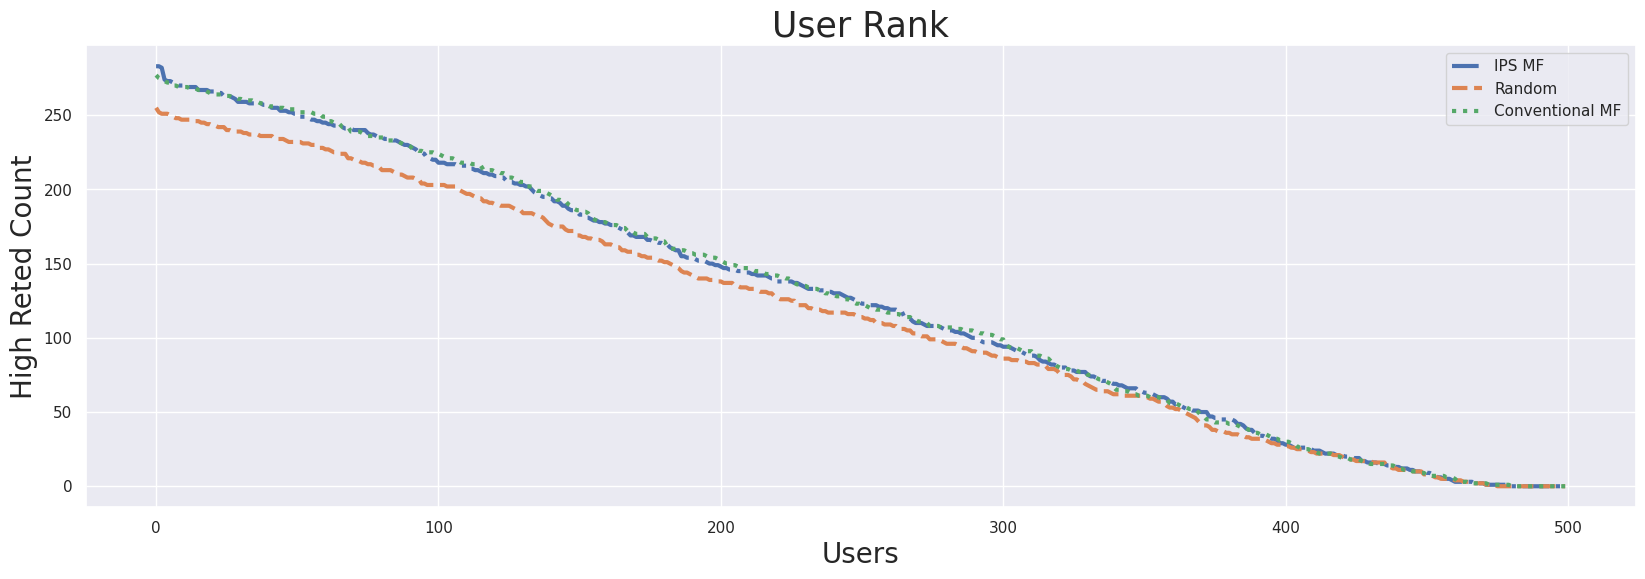

In [24]:
users = [u for u in range(num_user)]

plt.figure(figsize=(20,6))
#plt.plot(users, np.sort(np.count_nonzero(high_r, axis=1))[::-1], linewidth=3, label="True Matrix")
plt.plot(users, np.sort(np.count_nonzero(high_ips_mat, axis=1))[::-1], label="IPS MF", linewidth=3, linestyle="dashdot")
plt.plot(users, np.sort(np.count_nonzero(high_random_mat, axis=1))[::-1], label="Random", linewidth=3, linestyle="dashed")
plt.plot(users, np.sort(np.count_nonzero(high_mf_mat, axis=1))[::-1], label='Conventional MF', linewidth=3, linestyle="dotted")

plt.title('User Rank', fontdict=dict(size=25))
plt.xlabel("Users", fontdict=dict(size=20))
plt.ylabel("High Reted Count", fontdict=dict(size=20))

plt.legend()
plt.show()

In [23]:
# 公平ランキングα-NSWは上記のバイアスたちにポジションバイアスが加わり、それを補正するものと考えられる。
#つまり、普遍学習x公平ランキングはポジションバイアスxアルゴリズム交絡バイアスの掛け合わせを対処可能？？